# Programming Assignment 2 - Image Stitching

by Mark Jeremy G. Narag

This Programming Assignment has eight (8) steps which I will discuss one by one.

#### 1. Load images tower left.jpg and tower right.jpg and convert to double and to grayscale.

Instead of double, I will actually convert the images into float32 since that is the requirement of the Harris Detector of OpenCV which we will see in step 2:

(<Axes: title={'center': 'right'}>,
 Text(0.5, 1.0, 'right'))

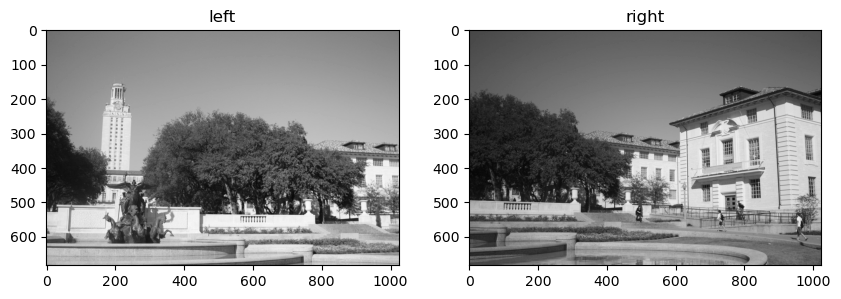

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

#loading the image using cv2.imread:
#I need to convert it from BGR to RGB since I will be using plt.imshow later
left = cv2.cvtColor(cv2.imread('imgpairs/tower_left.jpg'), cv2.COLOR_BGR2RGB) 
right = cv2.cvtColor(cv2.imread('imgpairs/tower_right.jpg'), cv2.COLOR_BGR2RGB)

#converting the BGR image into grayscale using cv2.cvtColor.
#we then add .astype(np.float64) to convert it to float32:
gray_left = cv2.cvtColor(left, cv2.COLOR_RGB2GRAY).astype(np.float32)
gray_right = cv2.cvtColor(right, cv2.COLOR_RGB2GRAY).astype(np.float32)

#plotting:
plt.figure(figsize = (10,5))
plt.subplot(121), plt.imshow(gray_left, cmap = 'gray'), plt.title('left')
plt.subplot(122), plt.imshow(gray_right, cmap = 'gray'), plt.title('right')

#### 2. Detect feature points in both images using a Harris Detector.

Harris detector is a corner detection operator for an image. Mathematically, the operator is defined as
$$f = \frac{\lambda_1 \lambda_2}{\lambda_1 \lambda_2} = \frac{determinant(H)}{trace(H)}$$

where $$H = 
\begin{bmatrix}
I_x^2 & I_x I_y\\
I_y I_x & I_y^2
\end{bmatrix}$$

The above term determines whether a window contains a corner or not:\
When $|f|$ is small ($λ_1$ and $λ_2$ are small), then the region is flat.\
When $f<0$ ($λ_1>>λ_2$ or vice versa), then the region is edge.\
When $f$ is large ($λ_1$ and $λ_2$ are large and $λ_1∼λ_2$), then the region is a corner.

In our code, we can use `cv.cornerHarris(img,blockSize,ksize,k)` function of OpenCV with input arguments:\
`img` - Input image. It should be grayscale and float32 type\
`blockSize` - It is the size of neighbourhood considered for corner detection\
`ksize` - Aperture parameter of the Sobel derivative used\
`k` - Harris detector free parameter in the equation

source: OpenCV: Harris Corner Detection. url: https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

(<Axes: title={'center': 'corners detected (right)'}>,
 Text(0.5, 1.0, 'corners detected (right)'))

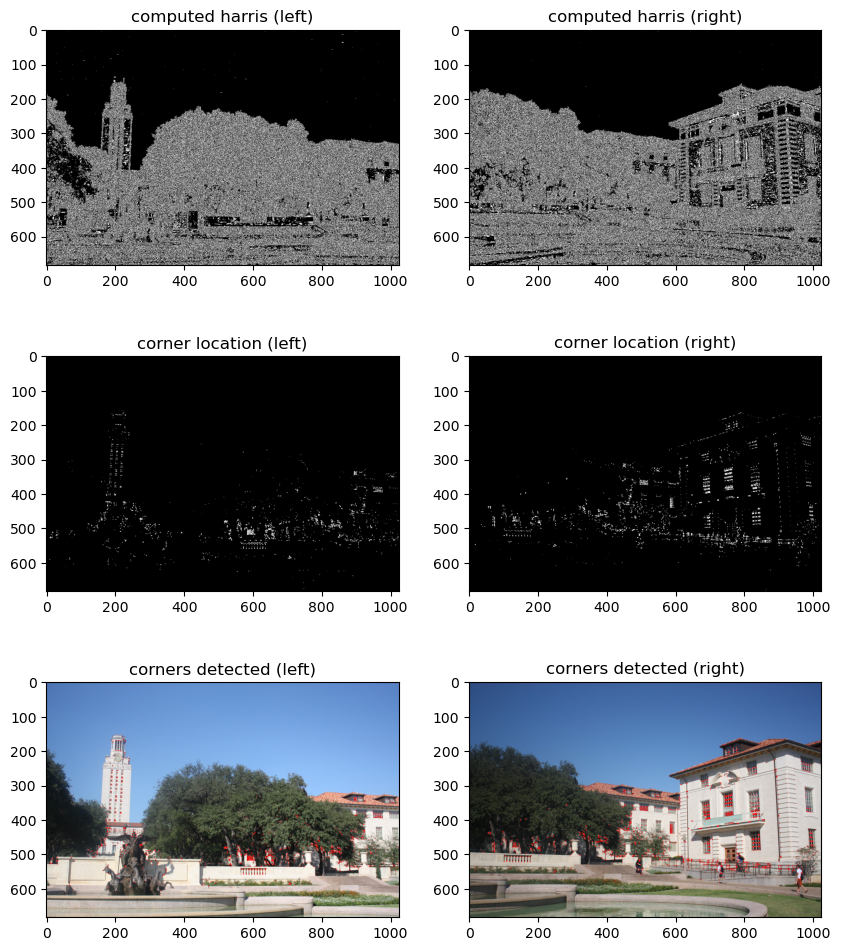

In [2]:
#As mentioned above, below is how we can use the Harris detector package of OpenCV.
#We will use a blockSize of 2by2, ksize of 3, and k=0.04. These are all arbitrary which we can explore:
harris_left = cv2.cornerHarris(gray_left, blockSize=2, ksize=3, k=0.04)
harris_right = cv2.cornerHarris(gray_right, blockSize=2, ksize=3, k=0.04)

#Visualizing
plt.figure(figsize = (10,12))
plt.subplot(321), plt.imshow(np.uint8(harris_left),cmap='gray'), plt.title('computed harris (left)')
plt.subplot(322), plt.imshow(np.uint8(harris_right),cmap='gray'), plt.title('computed harris (right)')

#Now, let us detect/identift the relevant feature points (corners) by thresholding the value of the Harris
#In this case, the pixels with a response above the threshold will be considered corners.
#The response is basically the value of "f" in our equation a while ago:
threshold = 0.02 #ofcourse we can change this
harris_left[harris_left < threshold * harris_left.max()] = 0 #anything lower than the thresh will be black
harris_left[harris_left > threshold * harris_left.max()] = 255 #anything higher than the thresh will be white
harris_right[harris_right < threshold * harris_right.max()] = 0
harris_right[harris_right > threshold * harris_right.max()] = 255
plt.subplot(323), plt.imshow(np.uint8(harris_left),cmap='gray'), plt.title('corner location (left)')
plt.subplot(324), plt.imshow(np.uint8(harris_right),cmap='gray'), plt.title('corner location (right)')

#-------FOR BETTER VISUALIZATION-----------#
left[harris_left > threshold * harris_left.max()] = [255,0,0] #this is RED
right[harris_right > threshold * harris_right.max()] = [255,0,0] 
plt.subplot(325), plt.imshow(left), plt.title('corners detected (left)')
plt.subplot(326), plt.imshow(right), plt.title('corners detected (right)')

We can see here that the red dots are actually the corners as expected. Specifically, let us focus on those buildings. See how we were able to get detect the corners of the windows and the walls! Note that this is just for visualization purposes. We will still work with the grayscaled version of the image.

#### Step 3: Extract fixed-size patches around every keypoint in both images, and form descriptors simply by ”flattening” the pixel values in each patch to one-dimensional vectors. Experiment with different patch sizes to see which one works best.

first corner coordinate =  [157 219]


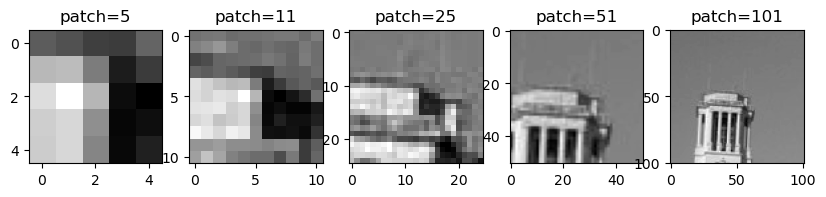

In [3]:
#We first need to find the coordinates of the corners and find which patch size works best.
#np.where will find the coordinates in thresholded harris_left where the value is equal to 255
corner_coordinates = np.column_stack(np.where(harris_left == 255))
print('first corner coordinate = ', corner_coordinates[0])# just to check
#print('number of corners detected(left)', len(corner_coordinates))#just checking again. Fewer corners mean faster computation


#Next, we extract a patch around every corner coordinates.
#Let's not flatten it first so we can visualize the best patch
def view_patches(image,patch_size,corner_coordinates): #we can change this but let us stick with this first
    patches = []
    for x, y in corner_coordinates:
        #let us calculate the coordinates for the top-left corner of the patch
        start_x = x - patch_size // 2
        start_y = y - patch_size // 2
        #then the bottom-right corner of the patch
        end_x = x + patch_size // 2
        end_y = y + patch_size // 2
        #then just to make sure that it will not go out of the image bounds
        if start_x >= 0 and start_y >= 0 and end_x < gray_left.shape[1] and end_y < gray_left.shape[0]:
            patch = image[start_x:end_x+1, start_y:end_y+1]
            patches.append(patch)
    return patches

plt.figure(figsize = (10,25))
plt.subplot(151), plt.imshow(view_patches(gray_left,5,corner_coordinates)[0],cmap='gray'),plt.title('patch=5')
plt.subplot(152), plt.imshow(view_patches(gray_left,11,corner_coordinates)[0],cmap='gray'),plt.title('patch=11')
plt.subplot(153), plt.imshow(view_patches(gray_left,25,corner_coordinates)[0],cmap='gray'),plt.title('patch=25')
plt.subplot(154), plt.imshow(view_patches(gray_left,51,corner_coordinates)[0],cmap='gray'),plt.title('patch=51')
plt.subplot(155), plt.imshow(view_patches(gray_left,101,corner_coordinates)[0],cmap='gray'),plt.title('patch=101')
plt.show()

The above images are the different patches for different patch sizes. The detected corners are the centers of each patch. Note that I made the patch size odd number so the corner coordinate will exactly be on the center.

From the images above, we can perhaps stick with patch = 11.

In [4]:
#Now, we flatten it using a fixed patch size = 11. We will just add .flatten()
def flattened_patches(image,corner_coordinates):
    patch_size = 11 #we can change this but let us stick with this first
    patches = []
    coords = []
    for x, y in corner_coordinates:
        #let us calculate the coordinates for the top-left corner of the patch
        start_x = x - patch_size // 2
        start_y = y - patch_size // 2
        #then the bottom-right corner of the patch
        end_x = x + patch_size // 2
        end_y = y + patch_size // 2
        #then just to make sure that it will not go out of the image bounds
        if start_x >= 0 and start_y >= 0 and end_x < gray_left.shape[0] and end_y < gray_left.shape[1]:
            patch = image[start_x:end_x+1, start_y:end_y+1].flatten()
            z = [x,y]
            coords.append(z)
            patches.append(patch)
    coords = np.array(coords)
    return patches, coords
left_corner_coordinates = np.column_stack(np.where(harris_left == 255))#getting the coordinates for left harris
print('left old coords = ',np.shape(left_corner_coordinates)) #just to check
right_corner_coordinates = np.column_stack(np.where(harris_right == 255))#getting the coordinates for right harris
left_patch,left_corner_coordinates = flattened_patches(gray_left,left_corner_coordinates)#getting the flatted version of patches for left image
right_patch, right_corner_coordinates = flattened_patches(gray_right,right_corner_coordinates)#getting the flatted version of patches for right image
#Since there are patches that we skipped, we should also update the left and right coorner coordinates
print('left new coords = ',np.shape(left_corner_coordinates)) #just to check
print('size of left patch = ',np.shape(left_patch)) #just to check

print('flattened patch 1 = ',left_patch[0])#just to check if we were able to flatten it
print('size = ',np.size(left_patch[0]))


left old coords =  (5213, 2)
left new coords =  (5192, 2)
size of left patch =  (5192, 121)
flattened patch 1 =  [151. 153. 154. 148. 150. 151. 152. 154. 154. 148. 157. 158. 162. 169.
 157. 148. 146. 150. 147. 145. 155. 149. 129. 133. 145. 147. 148. 149.
 154. 151. 144. 156. 149. 144. 140. 145. 140. 135. 126. 125. 144. 143.
 144. 150. 205. 199. 191. 185. 187. 156. 109. 124. 138. 144. 139. 203.
 199. 205. 203. 220. 184. 101.  95. 105. 117. 151. 206. 207. 209. 196.
 200. 165.  98. 102.  97.  97. 107. 200. 204. 191. 195. 200. 160.  99.
 111. 103. 103. 111. 217. 209. 200. 213. 208. 163. 103. 102. 104. 100.
 120. 168. 168. 172. 164. 164. 163. 159. 163. 164. 124. 141. 173. 191.
 176. 158. 153. 148. 148. 133. 155. 124. 145.]
size =  121


From above, we can see that we were able to extract the coordinates correctly. Then since our patch is 11 by 11, then we should have a one dimension vector of size 121, as printed.

#### 4. Compute the Euclidean distances between every descriptor in one image and every descriptor in the other image.

In our highschool math, Euclidean distance is basically just:
$$d = \sqrt{\sum_{i=1}^{i=n} (q_i - p_i)^2}$$
where $q_i$ and $p_i$ are the elements of the two vectors $q$ and $p$.
But luckily, we can just use `np.linalg.norm()` to compute for the Euclidean distances of two vectors.

In [5]:
#let's create a matrix where we will store the euclidean values:
euclidean_distances = np.zeros((len(left_patch), len(right_patch))) 
print('number of left patches',len(left_patch)) #just checking
print('number of right patches',len(right_patch)) #just checking
for i in range(len(left_patch)):
    for j in range(len(right_patch)):
        euclidean_distances[i, j] = np.linalg.norm(left_patch[i] - right_patch[j])


number of left patches 5192
number of right patches 8467


#### Step 5: Select the putative matches based on the matrix of pairwise descriptor distances obtained above. You can select all pairs whose descriptor distances are below a specified threshold, or select the top few hundred descriptor pairs with the smallest pairwise distances.

In [6]:
#Here, I will choose the top 200 descriptor pairs with the smallest pairwise distances:
#First is to get the indices of the top 500 descriptor pairs
indices = np.argsort(euclidean_distances, axis=None)[0:500]

#converting the flat indices into 2D indices
indices_2d = np.unravel_index(indices, euclidean_distances.shape)

#getting the actual descriptor pairs
selected_descriptor_pairs = list(zip(indices_2d[0], indices_2d[1]))

#just to check:
print('index (left,right):',selected_descriptor_pairs[0])
print('left image coordinate',left_corner_coordinates[selected_descriptor_pairs[0][0]])
print('right image coordinate',right_corner_coordinates[selected_descriptor_pairs[0][1]])
print('Euclidean distance:',euclidean_distances[selected_descriptor_pairs[0][0]][selected_descriptor_pairs[0][1]])

index (left,right): (2308, 4262)
left image coordinate [485 620]
right image coordinate [457 139]
Euclidean distance: 141.2515411376953


Remember that the `selected_descriptor_pairs` are the indices of the `left_corner_coordinates` and `right_corner_coordinates`. We still need to extract the coordinates!

The following code and plot is just me double checking the results :D

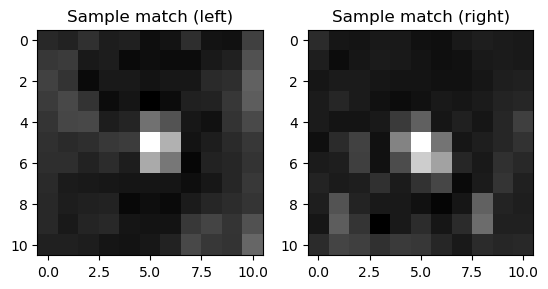

In [7]:
#let us check if they are really a match
#we can either unflatten the descriptor or extract the patch from the coordinate:
height = 11
width = 11
i=0 #change this for other patches
l = selected_descriptor_pairs[i][0]
r = selected_descriptor_pairs[i][1]
l_coor = left_corner_coordinates[selected_descriptor_pairs[i][0]]
r_coor = right_corner_coordinates[selected_descriptor_pairs[i][1]]
#reshaping the vector into a 2D array
imagel = left_patch[l].reshape((height, width))
imager = right_patch[r].reshape((height, width))

#plt.figure(figsize = (20,10))
#plt.subplot(121),plt.imshow(imagel, cmap='gray'), plt.title('Left match using unflattening')
#plt.subplot(122),plt.imshow(imager, cmap='gray'), plt.title('Right match using unflattening')

#this is just similiar to our view_patches function a while ago:
def check_patches(image,patch_size,x,y): 
    start_x = x - patch_size // 2 
    start_y = y - patch_size // 2
    end_x = x + patch_size // 2
    end_y = y + patch_size // 2
    patch = image[start_x:end_x+1, start_y:end_y+1]
    return patch
plt.subplot(121),plt.imshow(check_patches(gray_left,11,l_coor[0],l_coor[1]), cmap='gray')
plt.title('Sample match (left)')
plt.subplot(122),plt.imshow(check_patches(gray_right,11,r_coor[0],r_coor[1]), cmap='gray')
plt.title('Sample match (right)')
plt.show()

Looks pretty much correct :)

#### 6. Run RANSAC to estimate (1) an affine transformation and (2) a homography mapping one image onto the other. For each transformation, report the inlier number and the average residual (squared distance between the point coordinates in one image and the transformed coordinates of the matching point in the other image). Also, display the locations of inlier matches in both images.

Affine Transformation is just a linear mapping method that preserves points, straight lines, and planes. It includes translation, rotation, scaling, and shearing operations. In 2D, it can be represented as: $$\begin{bmatrix}
x'\\
y'
\end{bmatrix}
= 
\begin{bmatrix}
a & b & c\\
d & e & f
\end{bmatrix}
\begin{bmatrix}
x\\
y\\
1
\end{bmatrix}
$$
it is a $2\times 3$ matrix whose coefficients are a,b,c,d,e,f.


Homography Transformation can represent both linear and non-linear distortions, including perspective changes. It can be represented as

$$\begin{bmatrix}
x'\\
y'\\
w'
\end{bmatrix}
= 
M
\begin{bmatrix}
x\\
y\\
w
\end{bmatrix}
$$

It is $3\times 3$ matrix for 2D transformations. $w$ here is a scaling factor.

For the affine transform, we can use `cv2.estimateAffine2D` function. 
For the homography transform, we can use `cv2.findHomography` function.
For the residual, we can use `np.linalg.norm` function which basically gets the vector length between two points.


Affine Transformation:
Inlier Number: 23
Average Residual: 536.29004

Homography Transform:
Inlier Number: 14
Average Residual: 647.6354


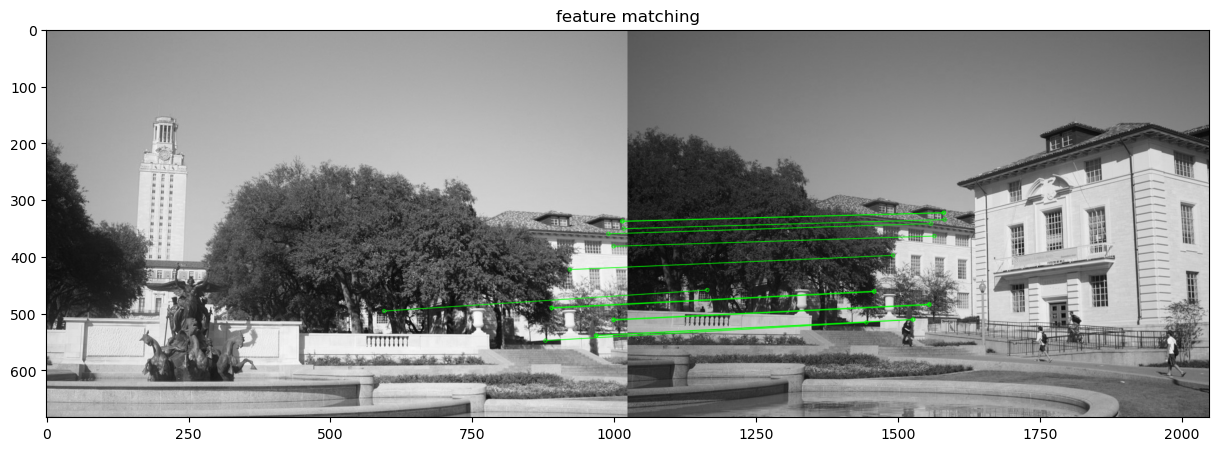

In [8]:
#Let us first get the coordinates from the top 500 descriptor pairs with lowest Euclidean distance
pts1 = [] #will hold the coordinates of the left image
pts2 = [] #will hold the coordinates of the right image
descriptor1 = [] #corresponding descriptor of the left image
descriptor2 = [] #corresponding descriptor of the right image
for i in range(0,500):
    xy = selected_descriptor_pairs[i][0] #coordinate of the left image
    uv = selected_descriptor_pairs[i][1] #coordinate of the right image
    array_left = left_corner_coordinates[xy]
    array_left[0], array_left[1] = array_left[1], array_left[0]#magkabaliktad kasi yung x and y
    array_right = right_corner_coordinates[uv]
    array_right[0], array_right[1] = array_right[1], array_right[0]#magkabaliktad
    pts1.append(array_left)
    pts2.append(array_right)
    descriptor1.append(left_patch[xy])
    descriptor2.append(right_patch[uv])
pts1 = np.array(pts1, dtype=np.float32) #converting it to array for the next computation
pts2 = np.array(pts2, dtype=np.float32) #converting it to array for the next computation

#let's look for the matches
#but the matching function wants the descriptor to be in numpy.ndarray format so we convert them:
descriptor1 = [[int(x) for x in row] for row in descriptor1] #it has to be an integer too
descriptor1 = np.array(descriptor1, dtype=np.uint8)
descriptor2 = [[int(x) for x in row] for row in descriptor2]
descriptor2 = np.array(descriptor2, dtype=np.uint8)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptor1, descriptor2)#this holds the index of the matching descriptors

#------Applying the RANSAC for Affine Transformation:
affine_transform, inliers = cv2.estimateAffine2D(pts1, pts2, ransacReprojThreshold=1.0)
#calculating residuals for the affine transformation:
transformed_pts_affine = cv2.transform(pts1.reshape(1, -1, 2), affine_transform)
#getting the squared distance between point coordinates and transformed coordinates using np.linalg.norm:
residuals_affine = np.linalg.norm(transformed_pts_affine.squeeze() - pts2, axis=1)
average_residual_affine = np.mean(residuals_affine) #getting the average
print("\nAffine Transformation:")
#Note that the inliers consists of 1s and 0s. We just need to sum it to get the total number of inliers:
print("Inlier Number:", np.sum(inliers)) 
print("Average Residual:", average_residual_affine)

#------Applying the RANSAC for Homography Transformation:
#but first we need to get the keypoints inside the matches then convert into suitable format:
keypoints1 = tuple([cv2.KeyPoint(x, y, 1) for x, y in pts1])#converting pts1 into a suitable cv2 keypoint format
keypoints2 = tuple([cv2.KeyPoint(x, y, 1) for x, y in pts2])#converting pts2 into a suitable cv2 keypoint format
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2) #matched keypoints on left image
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2) #matched keypoints on right image

homography_transform, inlier_h = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
#calculating residuals for Homography
transformed_pts_homography = cv2.perspectiveTransform(pts1.reshape(1, -1, 2), homography_transform)
residuals_homography = np.linalg.norm(transformed_pts_homography.squeeze() - pts2, axis=1)
average_residual_homography = np.mean(residuals_homography)
print("\nHomography Transform:")
print("Inlier Number:", np.sum(inlier_h))
print("Average Residual:", average_residual_homography)

#----- Let's draw the inlier matches
#we can't use the grayscaled version a while ago since it is in float32. 
#we need to read it again for the cv2.drawMatches() function
img1 = cv2.cvtColor(cv2.imread('imgpairs/tower_left.jpg'), cv2.COLOR_RGB2GRAY)
img2 = cv2.cvtColor(cv2.imread('imgpairs/tower_right.jpg'), cv2.COLOR_RGB2GRAY)
matchesMask = inlier_h.ravel().tolist()
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matchesMask, flags=2)
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, **draw_params)
plt.figure(figsize = (15,15)), plt.imshow(img_matches), plt.title('feature matching')
plt.show()

#### 7. Warp one image onto the other using the estimated transformation.

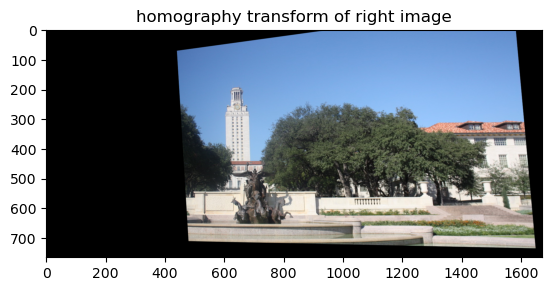

In [12]:
#remember that our original image have red dots already so let's just read it again:
left = cv2.cvtColor(cv2.imread('imgpairs/tower_left.jpg'), cv2.COLOR_BGR2RGB) 
right = cv2.cvtColor(cv2.imread('imgpairs/tower_right.jpg'), cv2.COLOR_BGR2RGB)
#warming the right image using our homography transform
warp = cv2.warpPerspective(left, homography_transform, (width, height))
plt.figure(), plt.imshow(warp), plt.title('homography transform of right image')
plt.show()

#### 8. Create a new image big enough to hold the panorama and composite the two images into it. You can composite by simply averaging the pixel values where the two images overlap. Write the composite image to a file called stitched output.jpg.

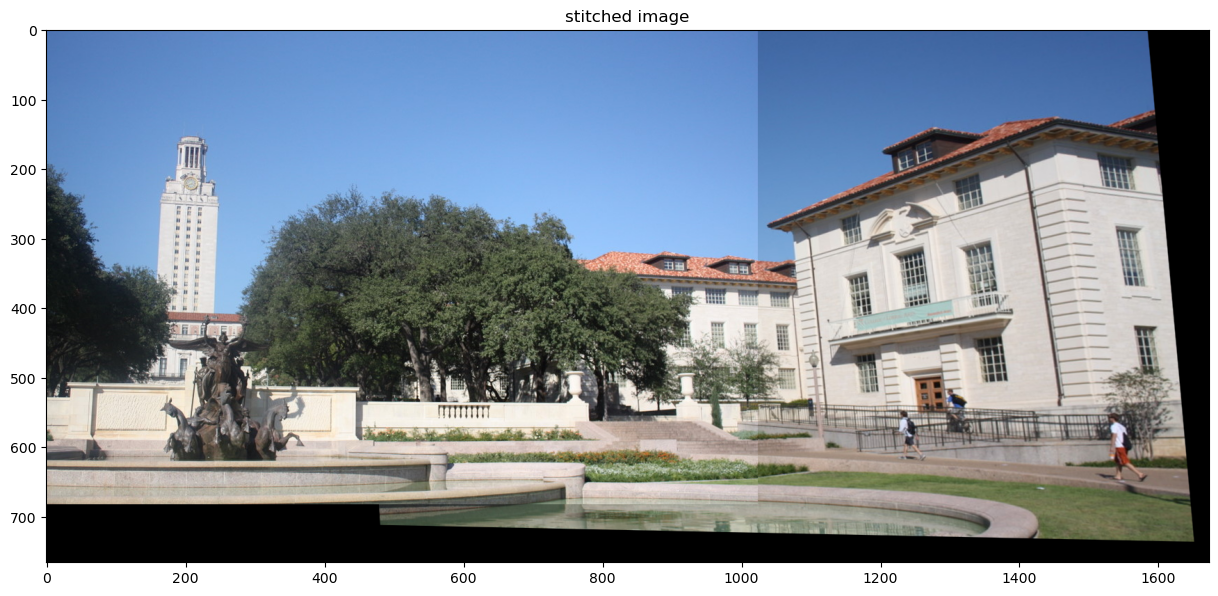

In [13]:
# Apply panorama correction             
width = right.shape[1] + left.shape[1] - 375 #the 300 is just an adjustment
height = right.shape[0] + left.shape[0] - 600 #same as 600 

stitch = cv2.warpPerspective(right, homography_transform, (width, height)) #getting the homography
stitch[0:right.shape[0], 0:right.shape[1]] = left#adding the left image

plt.figure(figsize=(15,10)), plt.imshow(stitch), plt.title('stitched image')
plt.show()

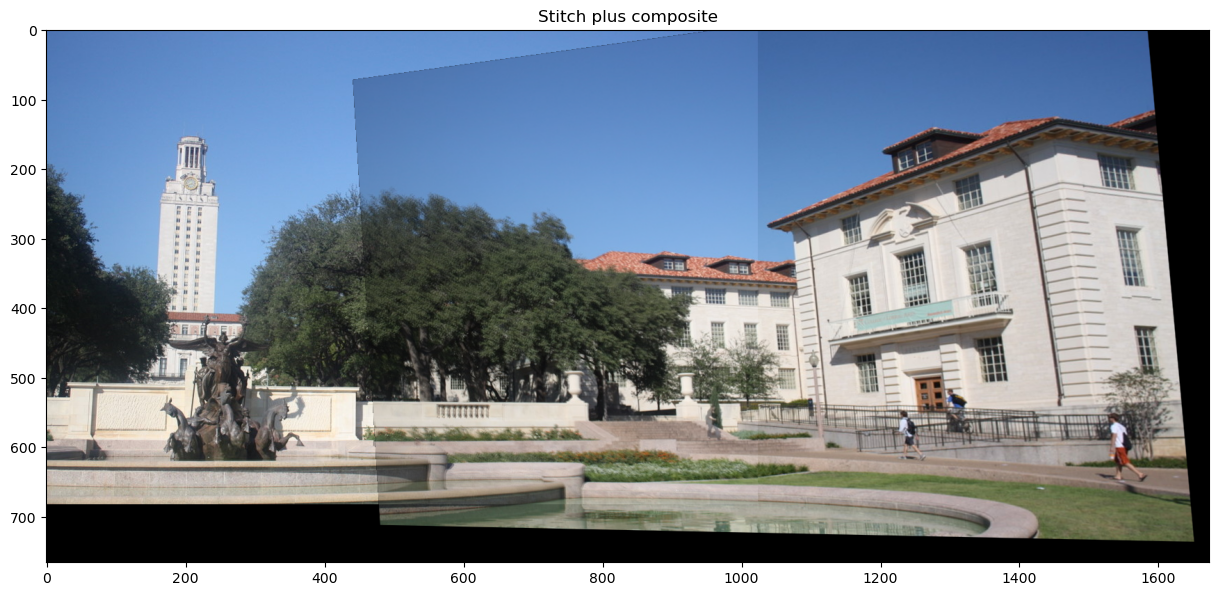

True

In [17]:
# Let's try to composite the images
left_warp = cv2.warpPerspective(right, homography_transform, (width, height)) #same as stitch
right_warp = np.zeros((height, width, 3), dtype=np.uint8) #let's create right image with same dimension as left_warp
right_warp[0:right.shape[0], 0:right.shape[1]] = left

output_image = np.zeros_like(left_warp)

# Iterate through each pixel
for i in range(height):
    for j in range(width):
        # let's check if the pixel intensity is zero on either image
        if left_warp[i, j].any() == 0 or right_warp[i, j].any() == 0:
            # if either intensity is zero, use the non-zero intensity
            output_image[i, j] = left_warp[i, j] + right_warp[i, j]
        else:
            # if both intensities are non-zero, we average them
            output_image[i, j] = (left_warp[i, j]/2 + right_warp[i, j]/2)

plt.figure(figsize=(15,10)), plt.imshow(output_image), plt.title('Stitch plus composite')
plt.show()
final = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)#we need to convert it to BGR since we are saving it using cv2
cv2.imwrite('stitched output.jpg', final)

I personally prefer the non-composite image. The previous image where we just add/overlay the left image on top of the right image. :D